<a href="https://colab.research.google.com/github/JMorrison17/AI/blob/main/Comparative_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The data set is a entity-level Twitter Sentiment analysis dataset, with the goal being to judge the sentiment of each tweet towards a given entity.

The training dataset contains ~70K rows.
Each Row contains a tweet ID, topic/entity, sentiment label and tweet content.

I decided to perform text classification on this dataset.
Originally the dataset contains 4 labels 'Positive','Negative','Neutral' and 'Irellevant' I decided to simplify to just Positive and Negative as the models perform much better.

I also only used the first 2000 rows about the entity 'Borderlands' to further simplify the task, and I also found that when doing 25k rows it took 1 hour to train and didn't provide any noticeable accuracy improvements.

In [1]:
import numpy as np #import numpy to enable array functionality
import io #io we use to load the data after uploading (as colab uses dictionaries to store uploaded files)
import pandas as pd
from google.colab import files #finally, we import the files package from google.colab framework to be able to upload files

uploaded = files.upload()
dataset = pd.read_csv('twitter_training.csv') #we will convert to a numpy array, where the first column is the text and the second column is the label


Saving twitter_training.csv to twitter_training (4).csv


In [2]:
print(dataset.iloc[:, 2].unique()) #check labels

['Positive' 'Neutral' 'Negative' 'Irrelevant']


In [3]:
#We want to only include Positive and Negatives as this is much more accurate than doing all 4
for x in dataset.index:
  #Check if any cell in the row contains 'Neutral' or 'Irrelevant' and then drop those rows
    if dataset.loc[x].isin(['Neutral','Irrelevant']).any():
        dataset.drop(x, inplace=True)

In [4]:
print(dataset.iloc[:, 2].unique())# check remaining labels

['Positive' 'Negative']


In [5]:
#keep only the tweet content and label
pdataset = dataset.iloc[:, [2, 3]]
#drop any rows containing missing values
pdataset = pdataset.dropna()
#limit dataset to first 2000 rows for speed and so it is only tweets about borderlands
pdataset = pdataset.iloc[:2000, :2]


print(pdataset.shape)
print(pdataset.head())
pdataset.info()

(2000, 2)
   Positive im getting on borderlands and i will murder you all ,
0  Positive  I am coming to the borders and I will kill you...   
1  Positive  im getting on borderlands and i will kill you ...   
2  Positive  im coming on borderlands and i will murder you...   
3  Positive  im getting on borderlands 2 and i will murder ...   
4  Positive  im getting into borderlands and i can murder y...   
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 3251
Data columns (total 2 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   Positive                                               2000 non-null   object
 1   im getting on borderlands and i will murder you all ,  2000 non-null   object
dtypes: object(2)
memory usage: 46.9+ KB


In [6]:
#convert from pandas to np
npdataset = pdataset.to_numpy()
#swap the position of rows
npdataset[:, [0, 1]] = npdataset[:, [1, 0]]
print(npdataset[:3])
#transpose
x, y = npdataset.T

[['I am coming to the borders and I will kill you all,' 'Positive']
 ['im getting on borderlands and i will kill you all,' 'Positive']
 ['im coming on borderlands and i will murder you all,' 'Positive']]


In [7]:
#This code was taken from the coursework example
import nltk #import the natural language toolkit

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords') #download the nltk package for stopwords

from nltk.tokenize import word_tokenize #import the tokenize package
from nltk.corpus import stopwords #import the package from the corpus
from nltk.stem.snowball import SnowballStemmer #import the snowball stemmer (also known as Porter2)

def prep(X):
      prep_text = []
      for x in X:
            token_text = word_tokenize(x) #tokenize the document
            normd_text = [token.lower() for token in token_text] #list compression to apply some simple cleaning (lower case casting and punctuation removal) to tokenized terms

            swr_text = [token for token in normd_text if token not in stopwords.words('english')] #list compression to remove any stopwords from our list

            stemmer = SnowballStemmer("english") #specify we are using the English stemming rules, as other languages are present in toolkit
            prep_text += [[stemmer.stem(word) for word in swr_text]] #list compression for applying the stemmer

      prep_sentences = [" ".join(sentence) for sentence in prep_text] #we join the sentences back together to ensure compatibility with CountVec, which is doing some of it's own prep
      return prep_sentences

prep_x = prep(x)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Representation Learning

To convert the textual data to numerical vectors I decided to use Word2Vec because I was familiar with it and it's quite a popular and easy to use option.

Word2Vec works by representing each word as a multi-dimensional vector, so that the meaning of the word can be interperted by the position of the word in multi-dimesional space

Word2Vec uses either Continuous bag of words(CBOW) or skip-gram, by default CBOW is used and that is what I used on this project. The difference between the two is that CBOW predicts the central word by using the context words surrounding it, which contain a few words before and after the current word. Skip-gram does the opposite it predicts the surrounding context words by using the central word.

In [8]:
from gensim.models import Word2Vec #import word2vec

In [9]:
import numpy as np

# Example of word2vec_rep function
def word2vec_rep(text, model):
    # Assuming text is tokenized into words
    vectors = [model.wv[word] for word in text if word in model.wv]
    if len(vectors) == 0:
        # Return a zero vector if no words found in the model
        return np.zeros(model.vector_size)
    # Average the word vectors to get a fixed-length vector for the text
    return np.mean(vectors, axis=0)

## Algorithms

#Linear SVC
Linear Support Vector Classification is a scalable version of SVC used for classification. LinearSVC like other versions of SVC is capable of performing muti-class and binary classification on a dataset. It is also different to other SVC due to using squared_hinge loss and its implementation in liblinear instead of libsvc, which gives it more possible variety in the choices of loss functions and penalties and so theoretically scales better to large sample counts.

I picked this alogrithm as scikit learn[1] reccomended it for classification

#Gradient Boosted Decision Trees

Gradient Boosted Decision Trees (GBDT) is an ensemble method like Random Forest, Ensemble methods work by combining the predictions of multiple base estimators with a given learning alogritm to improve robustness over a single estimator.

GradientBoostingClassifier supports both binary and multi-class classification much like LinearSVC, however HistGradientBoostingClassifier is better when dealing with a large number of classes, however we are only dealing with two classes so this works fine.


**References**
https://scikit-learn.org/stable/machine_learning_map.html [1]

In [10]:
#Code was taken from coursework example and modified
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
import numpy as np
prepn_x = np.array(prep_x)

lsvc_score = []
gbc_score = []

kf = StratifiedKFold(n_splits=5)


# Pre-train Word2Vec on the shortened dataset
w2v_model = Word2Vec(vector_size=300, window=5, min_count=3, workers=4)
w2v_model.build_vocab(prepn_x, update=None)
w2v_model.train(corpus_iterable=prepn_x, total_examples=len(prepn_x), epochs=10)

for train, test in kf.split(prepn_x, y):
    x_train, x_test, y_train, y_test = prepn_x[train], prepn_x[test], y[train], y[test]

    # Get word representations for train and test sets
    x_train_representations = [word2vec_rep(instance, w2v_model) for instance in x_train]
    x_test_representations = [word2vec_rep(instance, w2v_model) for instance in x_test]

    # Convert to NumPy arrays for lsvc and GBC
    x_train_representations = np.array(x_train_representations)
    x_test_representations = np.array(x_test_representations)


    lsvc = LinearSVC(random_state=0, tol=1e-5)
    lsvc.fit(x_train_representations, y_train)
    lsvc_predictions = lsvc.predict(x_test_representations)
    lsvc_acc = accuracy_score(lsvc_predictions, y_test)
    lsvc_score.append(lsvc_acc)

    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    gbc.fit(x_train_representations, y_train)
    gbc_predictions = gbc.predict(x_test_representations)
    gbc_acc = accuracy_score(gbc_predictions, y_test)
    gbc_score.append(gbc_acc)

# Print average accuracy of both models
print("GBC Accuracy:", np.mean(gbc_score), "lsvc Accuracy:", np.mean(lsvc_score))


GBC Accuracy: 0.633 lsvc Accuracy: 0.6759999999999999


## Evaluation

[Text(1, 0, 'GradientBoostingClassifier'), Text(2, 0, 'LinearSVC')]

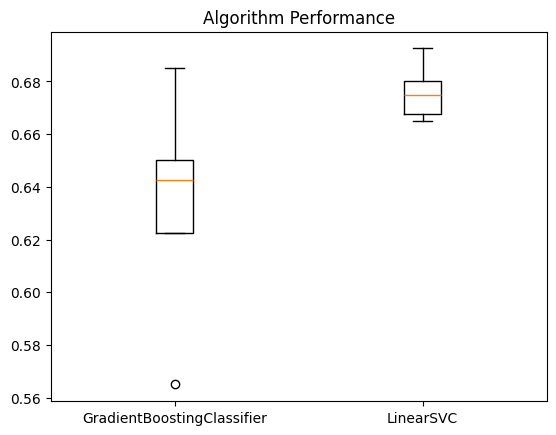

In [11]:
#Code was taken from coursework example and modified
import matplotlib as plt

#put model scores in an array
model_comp = []
model_comp.append(gbc_score)
model_comp.append(lsvc_score)

fig, ax2 = plt.pyplot.subplots()
ax2.set_title('Algorithm Performance')
ax2.boxplot(model_comp)
ax2.set_xticklabels(['GradientBoostingClassifier', 'LinearSVC'], rotation='horizontal')

As we can see from the results shown in the box plot, LinearSVC out performs the GradientBoostingClassifier when it comes to binary classification of the dataset.
However, I am wondering if better representation learning or tweaking some of the values of the algorithms would give us a better result, or whether trying different algorithms might be needed as they weren't as accurate as I'd like.